# Inteligentni sistemi genetsko programiranje za simbolično regresijo
**Genetski algoritm napisan v Pythonu**

Avtorja:

Luka Premuš, Domen Beden


### Knjižnice:

In [4]:
import pandas as pd
from r import *
from r2 import *
import numpy as np
import json
import math
from sympy import simplify
import matplotlib.pyplot as plt

data = pd.read_csv("./dataset.csv")
formule = data['Equation']


## Generiranje populacije

Za začetek delovanja genetskega algoritma je potrebna začetna populacija. V našem primeru je primerek iz populacije aritmetični izraz. 

Pri generiranju aritmetičnih izrazov naključno izberamo operacije in vrednosti v izrazih. 

**Možne operacije**: seštevanje (+), odštevanje (-), množenje (*), deljenje (/) in potenciranje (**)

**Možne vrednosti**: števila od 1 do 9, neodvisna spremenljivka $x$, naravni logaritem od števil 1 do 9, naravni logaritem od spremenljivke $x$ sinus od spremenljivke $x$, kosinus od spremenljivke $x$, od števil 1 do 9 in kosinus od števil 1 do 9. V naboru vrednosti, ki jih izbira algoritem pri izdelavi artimetične enačbe, se izbor "števila od 1 do 9" ponovi večkrat, saj s tem imajo večje verjetnosti, da so izbrane številke pri generaciji enačbe. S tem se izogneva izdelavi pretirane kompleksnosti enačb. 

Nato naključno generiramo število vrednosti, ki se nahaja med naravnim številom podanim z argumentom *numTerms* in *numTerms + 2*.

Funkcija *generate_expression* poleg tega, da naključno izbira operacije in vrednosti poskrbi tudi, da se v izrazu nahaja vsaj ena neodivsna spremenljivka $x$.

Funkcija se strogo izogiba enačbam, ki vsebujejo $x^{x}$. Te enčbe se izkažejo za težko obvladljive in pri njih hitro pride do **preliva** (ang. *Overflow*). 

In [147]:
def generate_expression(numTerms, x_index):
    operators = ["+", "-", "*","/", "**"]
    vals = [str(random.randint(1, 9)),str(random.randint(1, 9)),str(random.randint(1, 9)),str(random.randint(1, 9)),str(random.randint(1, 9)),str(random.randint(1, 9)),str(random.randint(1, 9)),
            str(random.randint(1, 9)),str(random.randint(1, 9)),
            str(random.randint(1, 9)),
              "x", f"log{str(random.randint(1,9))}",
              "logx","sinx","cosx",str(random.randint(1, 9)),str(random.randint(1, 9)),str(random.randint(1, 9)),str(random.randint(1, 9)),str(random.randint(1, 9)),
              f"sin{str(random.randint(1,9))}",
              f"cos{str(random.randint(1,9))}",str(random.randint(1, 9)),str(random.randint(1, 9)),str(random.randint(1, 9)),str(random.randint(1, 9))]
    vals2 = str(random.randint(1, 9))
    
    num_terms = random.randint(numTerms, 2+numTerms)
    
    x_index %= numTerms
    correct = False
    while not correct:
        correct = True
        terms = []
        del terms[:]
        x = 0
        for i in range(num_terms):
            
            op = random.choice(operators)
            num = random.choice(vals)

            if x_index == i:
                if i > 0 and terms[i-1] == "**":
                    correct = False
                    break     #da ne dobimo neki**x
                else:
                    num = "x"
                    x += 1
            else:
                if i > 0 and terms[i-1] == "**":
                    
                    if num == "x":
                        correct = False
                        break
            terms.append(num)
            terms.append(op)

        terms.append(vals2)
        expression = "".join(terms)

    return expression

Primeri 15 generiranih enačb z minimalno petimi vrednostmi:

In [149]:
for i in range(15):
    equation = generate_expression(5, i)
    print(f"{i}: {equation}")


0: x**2**cos8**3-7-4
1: 8*x**6**6/5-6**7-3
2: 2/6-x-log9+3-6-cos7+9
3: 3+8**8+x-3/3-8
4: 3-6/cos9+3**x-6+sinx*8
5: x-7*x+6**6/9*logx/8
6: 9/x*8**4+3/3
7: 9-4/x+1+1*9/1
8: 1+3*2-x*sinx+1+2+3
9: 9+logx/2**cos2**x**4
10: x*sinx**9*2*7/1
11: 6**x**8+5/5**1-4**8
12: 6+4/x+7*log8-x+2
13: 4-8*5*x+sin8**2-5+4
14: 7+4*logx+1/x**8**8+5


## Podatkovana strkutura podatkov

Kot je bilo podano v navodilih sva za podatkovno strkturo izbrala drevo. 
Drevo se gradi na podlagi prioritet v operacijah. Funkcija `fix2` preobrazi aritmetični izraz v ekvivalentnega, vendar glede na prioritete operacij postavi oklepaje. S tem si olajšava gradnjo drevesa.


In [7]:
def fix2(tokens):
    i = 0
    while i < len(tokens):
        if tokens[i] == "^":
            if i+1 < len(tokens) - 1 and tokens[i+1] == "(":
                #while
                n = i
                while tokens[n] != ")":
                    n += 1
                tokens.insert(n, ")")
            else:
                tokens.insert(i + 2, ")")
            #sam se v drugo smer ni b lema
            if tokens[i-1] == ")":
                m = i
                while tokens[m] != "(":
                    m -= 1
                tokens.insert(m, "(")
            else:
                tokens.insert(i - 1, "(")
            i += 1

        i += 1
    i = 0
    while i < len(tokens):
        if tokens[i] in "*/":
            if i+1 < len(tokens) - 1 and tokens[i+1] == "(":
                #while
                n = i
                while tokens[n] != ")":
                    n += 1
                tokens.insert(n, ")")
            else:
                tokens.insert(i + 2, ")")
            #sam se v drugo smer
            if tokens[i-1] == ")":
                m = i
                while tokens[m] != "(":
                    m -= 1
                tokens.insert(m, "(")
            else:
                tokens.insert(i - 1, "(")

            i += 1

        i += 1
    return tokens

Gradnja drevesa poteka v funkciji `build_tree`. Drevo ima v listih vrednosti, v vejah pa operacije. Zgrajeno je tako, da operacija, ki ima večjo prioriteto je globje kot pa operacija z manjšo. S tem poskrbiva, da je izračun drevesa pravilen, ko vstaviva notri vrednost.

In [8]:
def build_tree(tokens):

    stack = []
    tree = None

    for token in tokens:
        if token not in "*)^/+-(*":
            if token in "sxcxlxx":
                node = Node(token)
            else:
                if not token[0].isnumeric():
                    node = Node(token)
                else:
                    node = Node(int(token))
            stack.append(node)
        elif token == "(":

            stack.append(token)

        elif token in "+-*/^":
            right = stack.pop()
            left = stack.pop()

            
            node = Node(token)
            node.left = left
            node.right = right
            stack.append(node)
        
        elif token == ")":
            node = stack.pop()
            
            lastOp = node
            while node != "(":

                node = stack.pop()
            stack.append(lastOp)
    tree = stack.pop()
    return tree

Izračn drevesa poteka v funkciji `calculate_tree`. Na vhodu dobi koren drevesa, in vrednost, ki jo vsatavi namesto spremenljivke $x$. 

In [9]:
def calculate_tree(node, x):
    if type(node.value) == int:
        return int(node.value)
    if len(node.value) > 1 and node.value[0] == '-':
        return int(node.value)
    # sinus
    if node.value[0] == 's':
        if (node.value[1] == 'x'):
            return math.sin(x)
        value = node.value[1:]
        return math.sin(int(value))
    
    # cosinus
    if node.value[0] == 'c':
        if (node.value[1] == 'x'):
            return math.cos(x)
        value = node.value[1:]
        return math.cos(int(value))
    
    # logaritem
    if node.value[0] == 'l':
        if (node.value[1] == 'x'):
            return math.log(x)
        value = node.value[1:]
        return math.log(int(value))

    elif node.value == 'x':
        return x
    else:
        if node.value == '+':
            return calculate_tree(node.left,x) + calculate_tree(node.right,x)
        elif node.value == '-':
            return calculate_tree(node.left, x) - calculate_tree(node.right, x)
        elif node.value == '*':
            return calculate_tree(node.left, x) * calculate_tree(node.right, x)
        elif node.value == '/':
            x2 = calculate_tree(node.right, x)
            x1 = calculate_tree(node.left, x)

            if x2 == 0:
                return x1 // 1
            return x1 // x2

        elif node.value == '^':
            x1 = calculate_tree(node.left, x)
            if x1 < 0.0001:
                return 0
            
            x2 = calculate_tree(node.right, x)
            if x2 < 0.0001:
                return 0

            try:
                x3 = round(x1 ** x2)
                if x3 > 10_000_000:
                    return 10_000_000
                return round(x3,1)
            except OverflowError as e:
                return 10_000_000

# Fitness funkcije

Fitness funkcije so uporabljene za ocenjevanje primerkov. S temi ocenami lahko določimo kateri primeri se bodo ohranili in bodo uporabljeni za reprodukcijo. 

Najina fitness funkcija `fitness_MSE` deluje na principu `povprečju kvadratov napak`(ang. mean square error). Poleg tega pa upošteva še dolžino enačbe.

Funkcija `fitness_MSE` dobi na vhod predvideno enačbo, ki ji mora izračunati fitness, tabelo podatkov s pravilnimi enačbami, vhodi in izhodi, ter še index enačbe, ki jo trenutno iščemo.

Izračuna razliko med narvanim logaritmom pravilne vrednosti in naravnim logaritmom izračunano vrednostjo predvidene enačbe. Nato to kvadrira in doda na seznam rezultatov. Ko to izračunamo za vse vhode, seštejemo povprečne kvadratne napake in jih delimo s količino le teh. 

Nato to poračunamo še kazen glede na dolžino enačbe (krajše enačbe so manj kaznovane kot daljše), vse skupaj zaokrožimo na 5 decimalk in vrnemo.

In [10]:
def fitness_MSE(guess_eq, df, index):
    row = df.iloc[index]
    Xs = json.loads(row['Xs'])
    
    Ys = json.loads(row['Ys'])
    real_eq = row['Equation']

    tokens = parse_equation1(guess_eq)

    fix_tokens = fix2(tokens)
    sorted_tokens = sort_tokens(fix_tokens)
    tree = build_tree(sorted_tokens)
    fitnessVal = 0

    MSE_error = []
    for i in range(len(Xs)):
        rez = (calculate_tree(tree, int(Xs[i])))
        if (rez > 0):
            rez = math.log(rez)
        real_val = int((Ys[i]))
        if real_val > 0:
            real_val=math.log(real_val)

        sub = real_val - rez
        sub = sub
        try:
            MSE = (sub)**2
            # if MSE > 0:
            #     MSE = math.abs(MSE)
        except (OverflowError):
            return np.inf

        MSE_error.append(MSE)
        penalty = len(guess_eq)*0.1

    
    return round(sum(MSE_error)/len(MSE_error)+penalty,5)

## Mutacije

Mutacije se se izvajajo na dva načina tako da mutirajo vrednosti in tako da mutirajo operacije.

V funkciji `mutate_value` mutirava vrednosti. To počneva tako da z verjetnostjo $25$% zamenjava številko z novo vrednostjo iz nabora vrednosti.

V funkciji `mutate_operation` mutirava operacije. To počneva tako da z verjetnostjo $25$% zamenjava operacijo z novo operacijo iz nabora operacij.

*Nabor operacij*: seštevanje (+), odštevanje (-), množenje (*), deljenje (/), potenciranjej (^)


In [11]:
def mutate_value(expression):
    tokens = parse_equation1(expression)
    for i,c in enumerate(tokens):
        if c not in "x*/()-+" and c != "x":
            mutateBool = [True, False, False, False]
            if random.choice(mutateBool):
                rand_vals = [str(random.randint(-9, -1)),
                              str(random.randint(1, 9)), f"log{str(random.randint(1,9))}","logx","sinx","cosx",
                              f"sin{str(random.randint(1,9))}",f"cos{str(random.randint(1,9))}"]
                new_val = random.choice(rand_vals)
                tokens[i] = new_val
    return tokens


def mutate_operation(expression):
    tokens = parse_equation1(expression)
    for i,c in enumerate(tokens):
        # print(c)
        if c in "*/-+^":
            mutateBool = [True, False, False, False]
            if random.choice(mutateBool):
                rand_op = ["+", "-", "*","/", "**"]
                new_val = random.choice(rand_op)
                tokens[i] = new_val
    return tokens

## Križanje (ang. Crossover)

Križanje vzame dve **starštevski** vozlišči, prekopira njuno drevo ter shrani. Nato iz vsakega izmed teh podreves vzame naključno vozlišče. Ter zamenja ti dve vozlišči. Vrne kopiji dreves z zamenjanimi vozlišči.

Lahko se nam zgodi, da eno izmed novih dreves ne vsebuje nobene spremenljivke $x$. V takem primeru križanje ponovimo.

In [12]:
def crossover(parent1, parent2):

    child1 = copy_tree(parent1)
    child2 = copy_tree(parent2)


    node1 = get_random_node(child1)
    node2 = get_random_node(child2)

    temp_subtree = copy_tree(node1)
    
    node1.value = node2.value
    node1.left = node2.left
    node1.right = node2.right
    node2.value = temp_subtree.value
    node2.left = temp_subtree.left
    node2.right = temp_subtree.right

    return child1, child2

## Izvedba genetskega algoritma

Genetski algoritem se izvaja v funkciji `ga`. Na vhodu dobi *število primerkov* (N), ki bodo generirani v posamezni generaciji, *število generacij* (gen), *oznako enačbe* (ang. index), *muatcijski niz* `mutation_choice_arr` in minimalno dolžino enačb `defExpLen`. Na začetku algoritma se generira *N* enačb, za vsako se izračuna njen fitness. Enačbe in pripadojoči fitnessi se shranijo v slovar (ang. dictionary), ki je na koncu generiranja urejen naraščajoče po fitnessih. Nato se slovar razpolovi, ter začnejo mutacije in križanje. V vsaki iteraciji prehoda čez slovar, se slovar razpolovi. Toliko časa dokler v slovarju ne ostane samo en element. Ta element dodamo v nov slovar `best_of_gens`, v katerem s zbirajo najboljši primerki iz generacij. Čisto na koncu je izbran najboljši primerek iz `best_of_gens`, ki predstavlja najboljši pribljižek iskani enačbi. 

V seznamu *mutation_choice* so določene verjetnosti, kaj se zgodi s posamezno enačbo v vsaki iteraciji. Če je izbrana številka ena, pomeni da bodo mutirale **vrednosti**. Pri številki dve bodo mutirale **operacije**. Pri številki tri pa se zgodi **križanje**.


In [13]:
equationIndex = 10

mutation_choices = [[1,1,1,2,2,3,2,3,3,3,3,3,3,3,3,3,3,3,3,3], [1,1,1,2,2,2], [3], [2], [1]]

def ga(N, gen, equationIndex, mutation_choice_array=[1,1,1,2,2,3,2,3,3,3,3,3,3,3,3,3,3,3,3,3], defExpLen=5):
    
    prevN = N
    best_of_gens = {}
    for i in range(gen):
        results = {}
        N = prevN

        for i in range(N):
            expression = generate_expression(defExpLen, i)
            fitness = fitness_MSE(expression, data, equationIndex)
            results[fitness] = expression
    
        # N = N // 2
        
        result = sort_dict(results)
        new_dict = dict(list(result.items())[:N])

        while N > 1:
            for ele in new_dict:
                mutation_choice = random.choice(mutation_choice_array)

                if mutation_choice == 1:
                    expression = arr_to_string(mutate_value(result[ele]))   
                    fitness = fitness_MSE(expression, data, equationIndex)
                    
                    result[fitness] = expression
                if mutation_choice == 2:
                    expression = arr_to_string(mutate_operation(result[ele]))

                    fitness = (fitness_MSE(expression, data, equationIndex))
                    result[fitness] = expression

                if mutation_choice == 3:
                    tree1, tree2 = pick2trees(new_dict)
                    tree1, tree2 = crossover(tree1, tree2)

                    #ce ni x v enacbi ponavlja 
                    while(check_if_x(tree1) == False) or (check_if_x(tree2) == False):
                        tree1_str = print_infix_parenthesis(tree1)

                        tree2_str = print_infix_parenthesis(tree2)
                        # print(f"tree1: {tree1_str}, tree2: {tree2_str}")
                        tree1,tree2 = crossover(tree1,tree2)
                        

                    tree1_str = infixString(tree1)
                    tree2_str = infixString(tree2)
                    
                    fitness1 = fitness_MSE(tree1_str, data, equationIndex)
                    fitness2 = fitness_MSE(tree2_str, data, equationIndex)


                    result[fitness1] = tree1_str
                    result[fitness2] = tree2_str

                    

            N = N // 2
            result = sort_dict(results)
            new_dict = dict(list(result.items())[:N]) 
        
        #vrne najboljsega iz generacije
        val = list(sort_dict(results))[0]
        # val = [simplify(results[]) : e in ]
        best_of_gens[val] = (results[val])
        # best_of_gens[val] = simplify(results[val])

        # print("best of gen: " + results[val] + " " + str(val))

    return best_of_gens

k = ga(100, 100, equationIndex)
k = sort_dict(k)


val = list(k)[0]

row = data.iloc[equationIndex]
Xs = json.loads(row['Xs'])

Ys = json.loads(row['Ys'])
real_eq = row['Equation']
print("---------------------")

print(real_eq)
print("---------------------")

print(k[val], val)




---------------------
(((x - 2) + 4) * 5)
---------------------
x-x/5+x*5+9 1.11838


V spodnjem odseku je zagnan genetski algoritem nad celotnimi podatki.

In [118]:
function_accuracy = []

for eqIndex in range(0, len(data)-80):
    
    k = ga(800, 20, eqIndex)
    k = sort_dict(k)

    val = list(k)[0]

    row = data.iloc[eqIndex]
    Xs = json.loads(row['Xs'])

    Ys = json.loads(row['Ys'])
    real_eq = row['Equation']
    print("---------------------")
    print(f"{eqIndex} - real eq: " + real_eq)
    print("=====================")
    print(simplify(k[val]), val)
    print("---------------------")
    function_accuracy.append(val)


---------------------
0 - real eq: ((x ** 4) - 6)
-sin9 + x**4 2.10173
---------------------
---------------------
1 - real eq: (((x / 8) * 2) + 1)
x/6 + 4 1.22409
---------------------
---------------------
2 - real eq: (((x - 1) - 3) / 5)
x/7 + 1/64 1.1648
---------------------
---------------------
3 - real eq: (x * 5)
45*x/7 + 1 1.10057
---------------------
---------------------
4 - real eq: (x + 2)
4*x/3 + 2 1.1
---------------------
---------------------
5 - real eq: ((x + 1) * 7)
7*x + 5 1.10057
---------------------
---------------------
6 - real eq: ((x + 2) ** 9)
5764801*x**(logx + 1) 8.93488
---------------------
---------------------
7 - real eq: (x * 2)
7*x/3 1.10623
---------------------
---------------------
8 - real eq: (((x ** 8) * 5) / 3)
4117715*x**logx + log1*x/cosx 13.03652
---------------------
---------------------
9 - real eq: (x / 7)
x**2/512 + 1 1.43153
---------------------
---------------------
10 - real eq: (((x - 2) + 4) * 5)
4*x + 33 1.1375
-------------

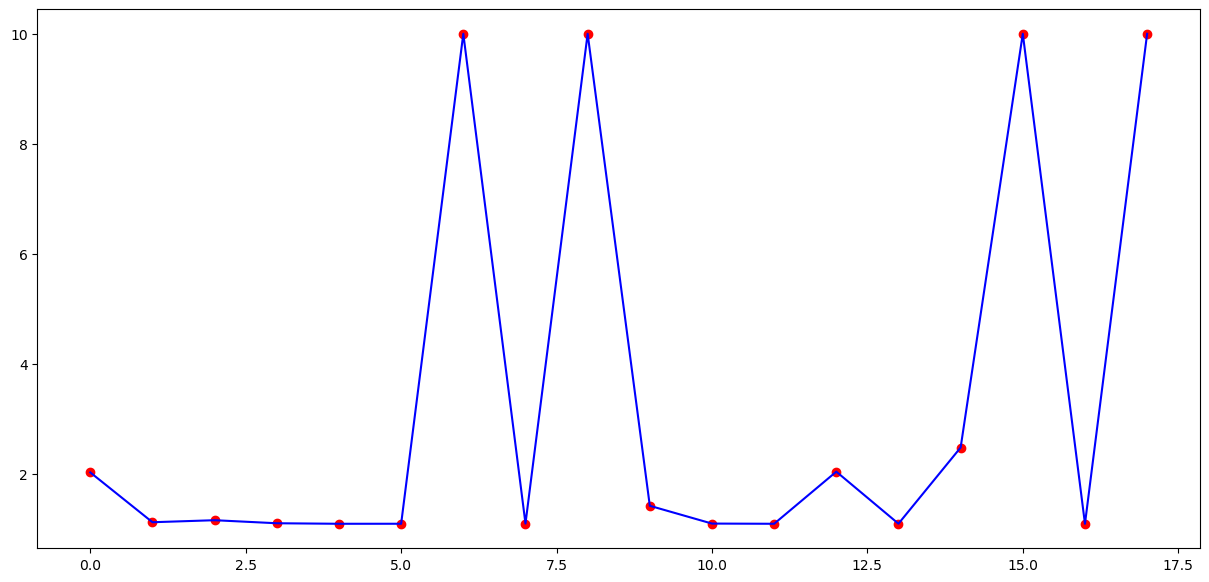

In [83]:
values = function_accuracy.copy()
values = [10 if v > 10 else v for v in values]
plt.figure(figsize=(15, 7))

xs = np.arange(len(function_accuracy))
plt.scatter(xs,values,color='red',marker='o')
plt.plot(xs,values,color='blue')


## Evaluacija
Primerjave v rezultatih med različnimi velikostmi populacij ter generacij. Večja kot je populacija in več kot je generacij, večja je časovna zahtevnost. 

1. 200 primerkov, 40 generacij

In [16]:
function_accuracy1 = []
for eqIndex in range(0, len(data)):
    
    k = ga(200, 40, eqIndex)
    k = sort_dict(k)

    val = list(k)[0]

    function_accuracy1.append(val)

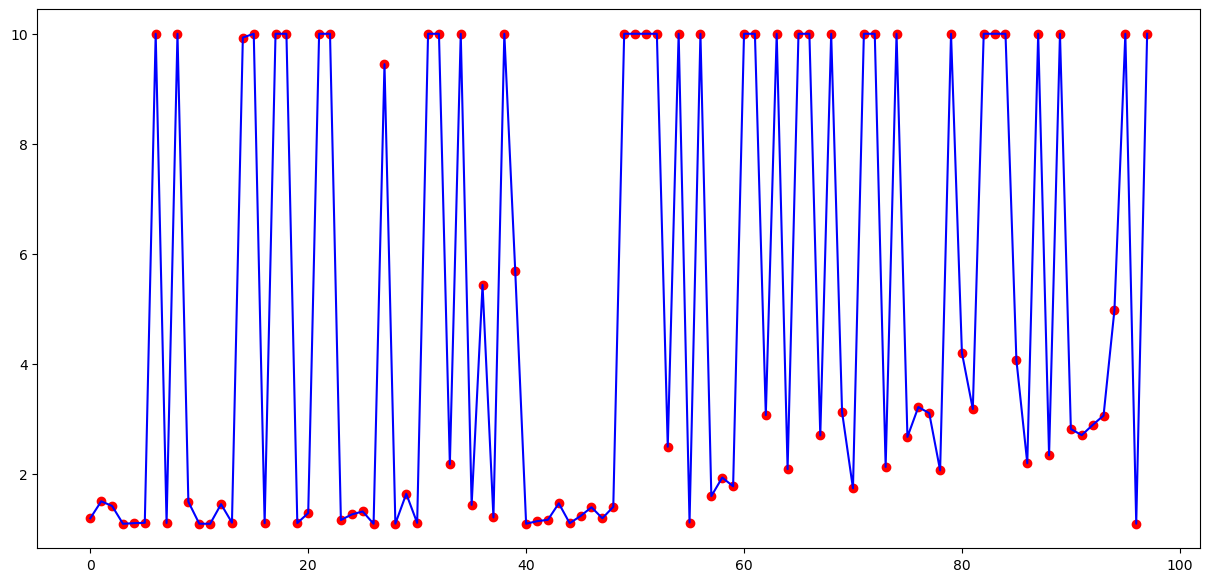

In [82]:
values = function_accuracy1.copy()

values = [10 if v > 10 else v for v in values]
plt.figure(figsize=(15, 7))

xs = np.arange(len(values))
plt.scatter(xs,values,color='red',marker='o')
plt.plot(xs,values,color='blue')

In [18]:
function_accuracy2 = []
for eqIndex in range(0, len(data)):
    
    k = ga(50, 50, eqIndex)
    k = sort_dict(k)

    val = list(k)[0]

    function_accuracy2.append(val)

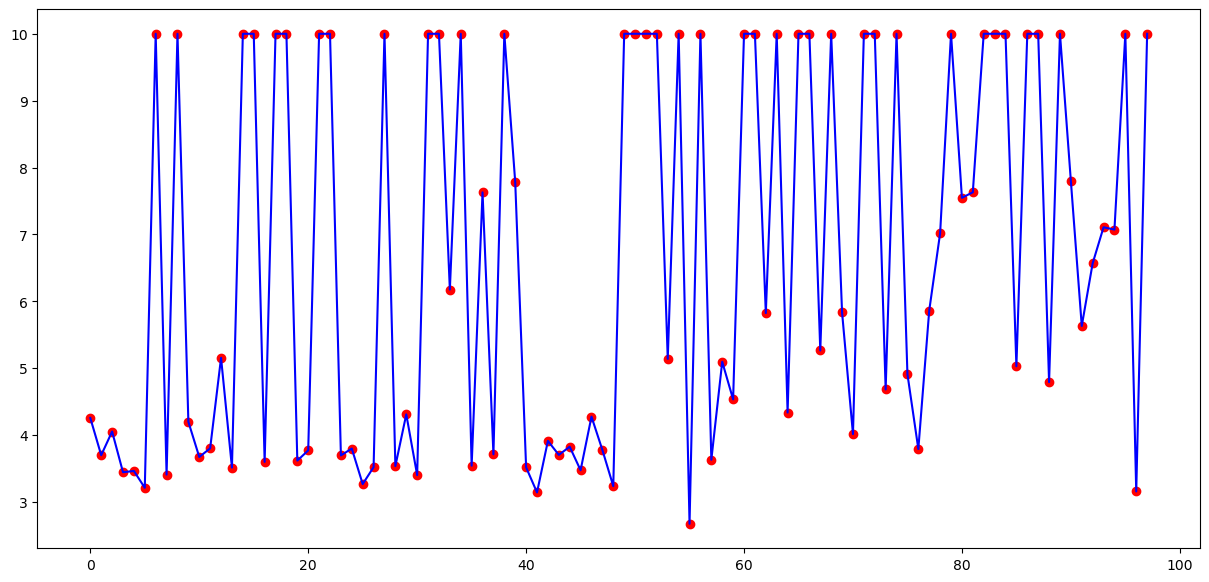

In [81]:
values = function_accuracy2.copy()

values = [10 if v > 10 else v for v in values]

plt.figure(figsize=(15, 7))
xs = np.arange(len(values))
plt.scatter(xs,values,color='red',marker='o')
plt.plot(xs,values,color='blue')

In [20]:
function_accuracy3 = []
for eqIndex in range(0, len(data)):
    
    k = ga(100, 100, eqIndex)
    k = sort_dict(k)

    val = list(k)[0]

    function_accuracy3.append(val)

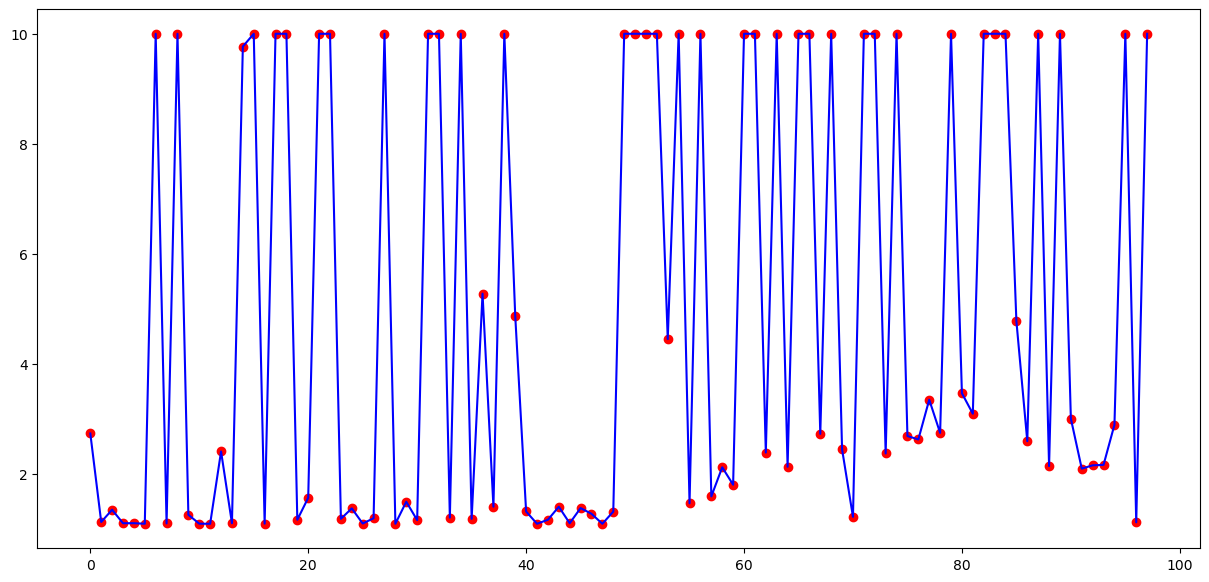

In [80]:
values = function_accuracy3.copy()

values = [10 if v > 10 else v for v in values]

plt.figure(figsize=(15, 7))
xs = np.arange(98)
plt.scatter(xs,values,color='red',marker='o')
plt.plot(xs,values,color='blue')

In [22]:
function_accuracy4 = []
for eqIndex in range(0, len(data)):
    
    k = ga(800, 50, eqIndex)
    k = sort_dict(k)

    val = list(k)[0]

    function_accuracy4.append(val)

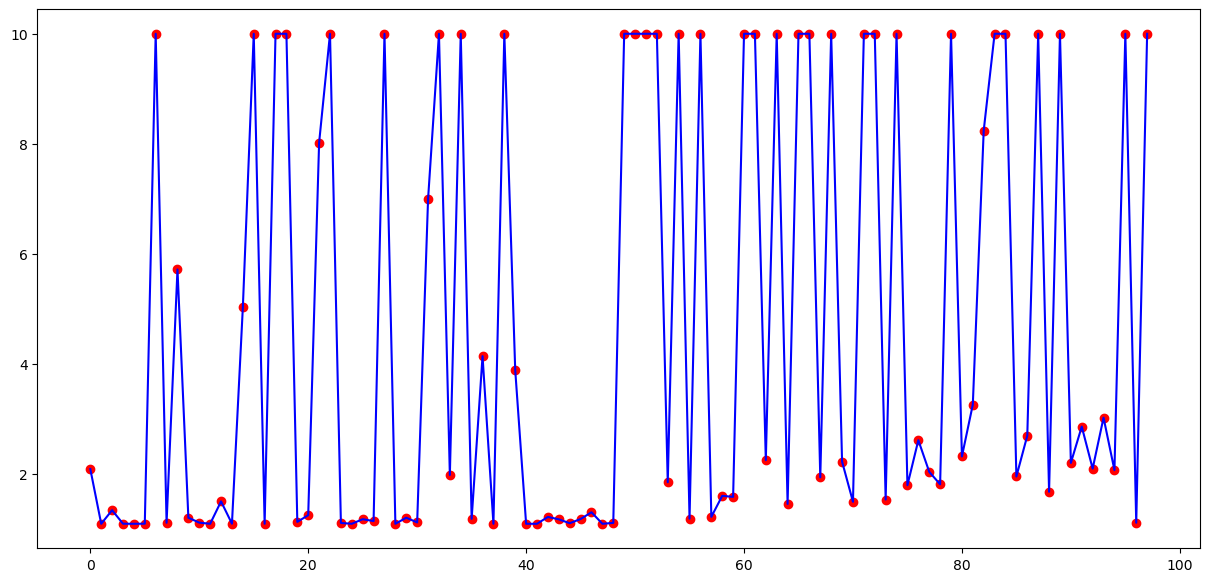

In [79]:
values = function_accuracy4.copy()

values = [10 if v > 10 else v for v in values]

plt.figure(figsize=(15, 7))
xs = np.arange(98)
plt.scatter(xs,values,color='red',marker='o')
plt.plot(xs,values,color='blue')

In [24]:
function_accuracy5 = []
for eqIndex in range(0, len(data)):
    
    k = ga(200, 300, eqIndex)
    k = sort_dict(k)

    val = list(k)[0]

    function_accuracy5.append(val)

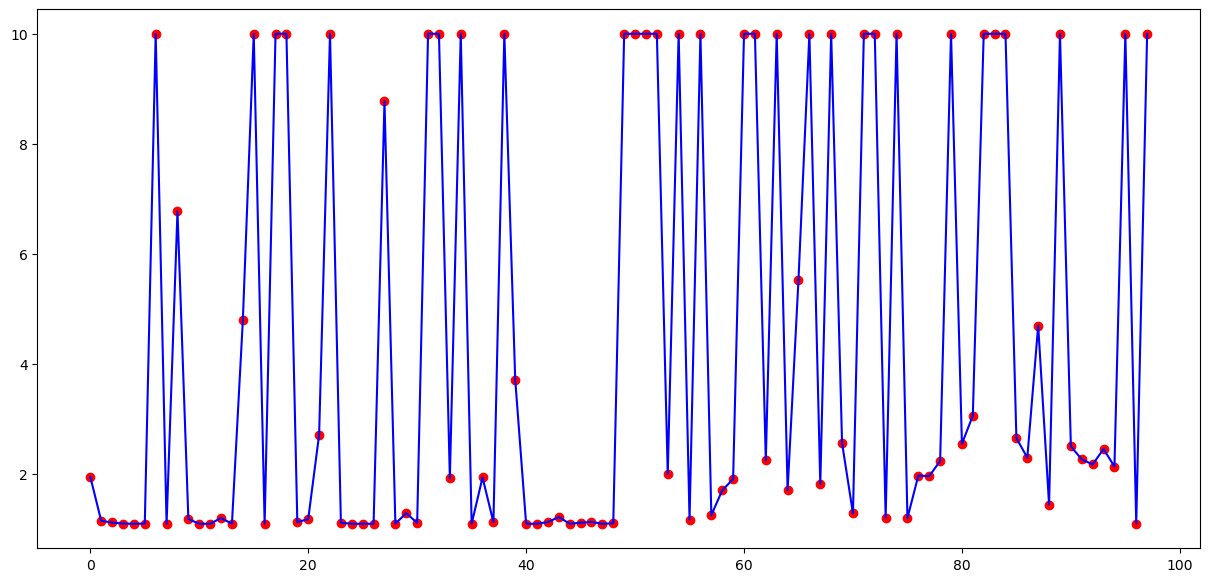

In [78]:
values = function_accuracy5.copy()

values = [10 if v > 10 else v for v in values]

plt.figure(figsize=(15, 7))
xs = np.arange(98)
plt.scatter(xs,values,color='red',marker='o')
plt.plot(xs,values,color='blue')

Na spodnjih grafih je prikazano kakšna je razlika med natančnostjo enačb, koliko in kako mutirmao ter križamo pri velikosti populacije 200 in 10 generacijah.

In [26]:
mutation_choices = [[1,1,1,2,2,3,2,3,3,3,3,3,3,3,3,3,3,3,3,3], [1,1,1,2,2,2]]
function_accuracy22 = []

for i, mutation_choice in enumerate(mutation_choices):
    function_accuracy2 = []
    print(f"Mutation choice index: {i}")
    for eqIndex in range(0, len(data)):
        
        k = ga(200, 10, eqIndex, mutation_choice)
        k = sort_dict(k)

        val = list(k)[0]

        function_accuracy2.append(val)
    function_accuracy22.append(function_accuracy2)



Mutation choice index: 0
Mutation choice index: 1


In [27]:
df = pd.DataFrame(np.array(function_accuracy22).T)
df.to_csv('DifMutationChoices.csv', index=False, header=False)

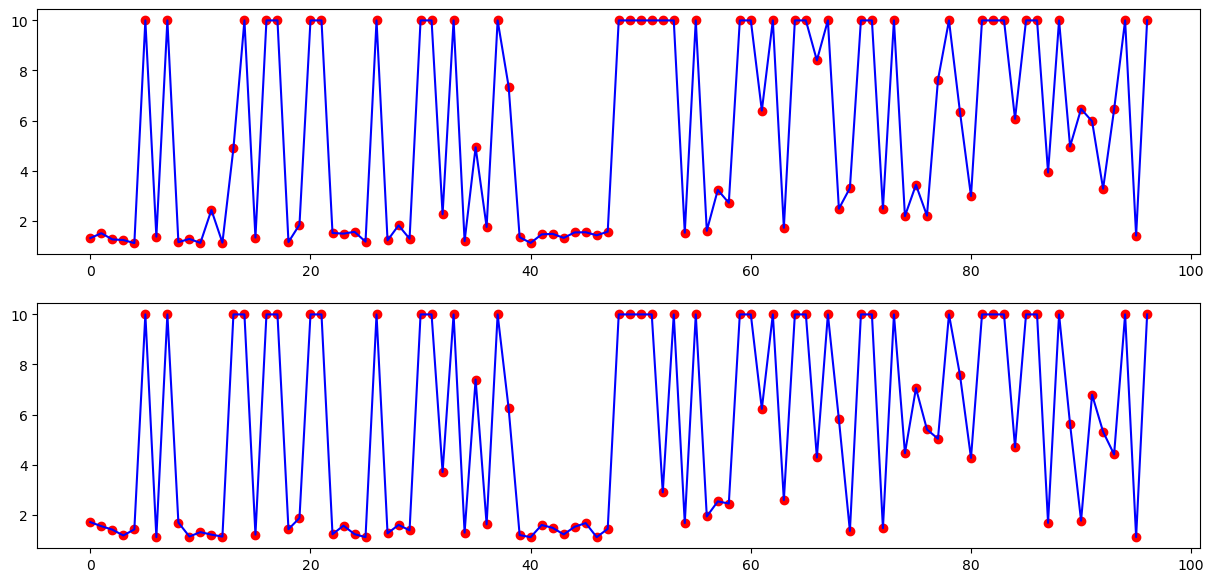

In [77]:
function_acc = pd.read_csv("./DifMutationChoices.csv", sep=',')
rowsCount = function_acc.shape[1]
plt.figure(figsize=(15, 7))

for i in range(rowsCount):
    curRow = function_acc.iloc[:,i]
    values = [10 if v > 10 else v for v in curRow]
    xs = np.arange(len(values))
    plt.subplot(2, 1, i + 1)
    plt.scatter(xs,values,color='red',marker='o')
    plt.plot(xs,values,color='blue')

plt.show()


In [29]:
mutation_choices = [[1],[2],[3]]
function_accuracy23 = []

for i, mutation_choice in enumerate(mutation_choices):
    function_accuracy2 = []
    print(f"Mutation choice index: {i}")

    for eqIndex in range(0, len(data)):
        
        k = ga(200, 10, eqIndex, mutation_choice)
        k = sort_dict(k)

        val = list(k)[0]

        function_accuracy2.append(val)
    function_accuracy23.append(function_accuracy2)


Mutation choice index: 0
Mutation choice index: 1
Mutation choice index: 2


In [30]:
df = pd.DataFrame(np.array(function_accuracy23).T)
df.to_csv('DifMutationChoices2.csv', index=False, header=False)

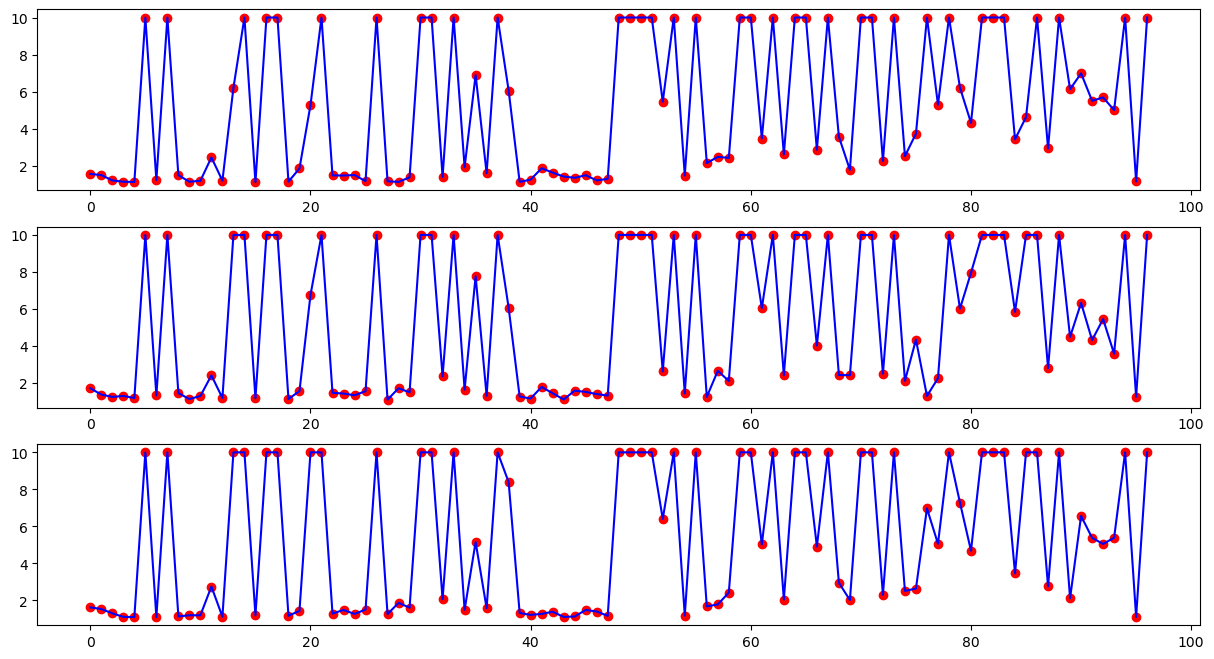

In [76]:
function_acc = pd.read_csv("./DifMutationChoices2.csv", sep=',')
rowsCount = function_acc.shape[1]
plt.figure(figsize=(15, 8))

for i in range(rowsCount):
    curRow = function_acc.iloc[:,i]
    values = [10 if v > 10 else v for v in curRow]
    xs = np.arange(len(values))
    plt.subplot(3, 1, i + 1)
    plt.scatter(xs,values,color='red',marker='o')
    plt.plot(xs,values,color='blue')

plt.show()
    



In [50]:
def generate_expression_type(numTerms, x_index, type):
    if type == 1:
        operators = ["+", "-", "*","/", "**"]
        vals = [str(random.randint(1, 9)),str(random.randint(1, 9)),
                str(random.randint(1, 9)),str(random.randint(1, 9)),
                str(random.randint(1, 9)),
                "x", f"log{str(random.randint(1,9))}",
                "logx","sinx","cosx",
                f"sin{str(random.randint(1,9))}",
                f"cos{str(random.randint(1,9))}"]
        vals2 = str(random.randint(1, 9))
        
        num_terms = random.randint(numTerms, 2+numTerms)
    if type == 2:
        operators = ["+", "-"]
        vals = [str(random.randint(1, 9)),str(random.randint(1, 9)),
            str(random.randint(1, 9)),str(random.randint(1, 9)),
            str(random.randint(1, 9)),
            "x"]
        vals2 = str(random.randint(1, 9))
    
        num_terms = random.randint(numTerms, 2+numTerms)
    if type == 3:
        operators = ["*","/", "**"]
        vals = [str(random.randint(1, 9)),str(random.randint(1, 9)),
                str(random.randint(1, 9)),str(random.randint(1, 9)),
                str(random.randint(1, 9)),
                "x"]
        vals2 = str(random.randint(1, 9))
        
        num_terms = random.randint(numTerms, 2+numTerms)
    
    x_index %= numTerms
    correct = False
    while not correct:
        correct = True
        terms = []
        del terms[:]
        x = 0
        for i in range(num_terms):
            
            op = random.choice(operators)
            num = random.choice(vals)

            if x_index == i:
                if i > 0 and terms[i-1] == "**":
                    correct = False
                    break     #da ne dobimo neki**x
                else:
                    num = "x"
                    x += 1
            else:
                if i > 0 and terms[i-1] == "**":
                    
                    if num == "x":
                        correct = False
                        break
            terms.append(num)
            terms.append(op)

        terms.append(vals2)
        expression = "".join(terms)

    return expression

Posodoblena funkcija `ga_N`, namesto najboljšega primerka iz generacije izbere najboljših $n$, v najnem primeru je $n = 5$.
Na koncu izvaja *križanje* na vseh najboljših primerkih. 

V dosti primerih dobiva boljši rezultat.

In [154]:
equationIndex = 54

mutation_choices = [[1,1,1,2,2,3,2,3,3,3,3,3,3,3,3,3,3,3,3,3], [1,1,1,2,2,2], [3], [2], [1]]

def ga_N(N, gen, equationIndex, mutation_choice_array=[1,1,1,2,2,3,2,3,3,3,3,3,3,3,3,3,3,3,3,3], defExpLen=5):
    
    prevN = N
    best_of_gens = {}
    for i in range(gen):
        results = {}
        N = prevN

        for i in range(N):
            expression = generate_expression(defExpLen, i)
            fitness = fitness_MSE(expression, data, equationIndex)
            results[fitness] = expression
    
        # N = N // 2
        
        result = sort_dict(results)
        new_dict = dict(list(result.items())[:N])

        while N > 5:
            for ele in new_dict:
                mutation_choice = random.choice(mutation_choice_array)

                if mutation_choice == 1:
                    expression = arr_to_string(mutate_value(result[ele]))   
                    fitness = fitness_MSE(expression, data, equationIndex)
                    
                    result[fitness] = expression
                if mutation_choice == 2:
                    expression = arr_to_string(mutate_operation(result[ele]))

                    fitness = (fitness_MSE(expression, data, equationIndex))
                    result[fitness] = expression

                if mutation_choice == 3:
                    tree1, tree2 = pick2trees(new_dict)
                    tree1, tree2 = crossover(tree1, tree2)

                    #ce ni x v enacbi ponavlja 
                    while(check_if_x(tree1) == False) or (check_if_x(tree2) == False):
                        tree1_str = print_infix_parenthesis(tree1)

                        tree2_str = print_infix_parenthesis(tree2)
                        # print(f"tree1: {tree1_str}, tree2: {tree2_str}")
                        tree1,tree2 = crossover(tree1,tree2)
                        

                    tree1_str = infixString(tree1)
                    tree2_str = infixString(tree2)
                    
                    fitness1 = fitness_MSE(tree1_str, data, equationIndex)
                    fitness2 = fitness_MSE(tree2_str, data, equationIndex)


                    result[fitness1] = tree1_str
                    result[fitness2] = tree2_str

                    

            N = N // 2
            result = sort_dict(results)
            new_dict = dict(list(result.items())[:N]) 
        
        #vrne najboljsega iz generacije
        val = list(sort_dict(results))
        for v in val:
            best_of_gens[v] = results[v]
            # print(v)
        # val = [simplify(results[]) : e in ]
        # best_of_gens[val] = (results[val])
        # best_of_gens[val] = simplify(results[val])

        # print("best of gen: " + results[val] + " " + str(val))
    results = len(best_of_gens)
    for el in range(results):
        tree1, tree2 = pick2trees(best_of_gens)
        tree1, tree2 = crossover(tree1, tree2)

        #ce ni x v enacbi ponavlja 
        # print(el)
        while(check_if_x(tree1) == False) or (check_if_x(tree2) == False):
            # tree1_str = print_infix_parenthesis(tree1)

            # tree2_str = print_infix_parenthesis(tree2)
            # print(f"tree1: {tree1_str}, tree2: {tree2_str}")
            tree1,tree2 = crossover(tree1,tree2)
            

        tree1_str = infixString(tree1)
        tree2_str = infixString(tree2)
        
        fitness1 = fitness_MSE(tree1_str, data, equationIndex)
        fitness2 = fitness_MSE(tree2_str, data, equationIndex)


        best_of_gens[fitness1] = tree1_str
        best_of_gens[fitness2] = tree2_str

    return best_of_gens

k = ga(500, 10, equationIndex)
k2 = ga_N(500, 10, equationIndex)

k = sort_dict(k)
k2 = sort_dict(k2)



val1 = list(k)[0]
val2 = list(k2)[0]

row = data.iloc[equationIndex]
Xs = json.loads(row['Xs'])

Ys = json.loads(row['Ys'])
real_eq = row['Equation']
print("---------------------")

print(real_eq)
print("---------------------")

print(k[val1], val1)
print(k2[val2], val2)



---------------------
 -4*x**4 + -2*x**3 + 1*x + -2
---------------------
1+8-x/sin8/8*x**7 6947624092050954.0
7 ^ 2 - 8 * lx ^ 9 * 8 / s3 - sx / sx - x ^ cx + 8 4646033485573663.0


Funkcija `ga_generating` išče kakšne bi bile enačbe če na njih nebi izvajali mutacij in križanj.

In [61]:
def ga_generating(N, gen, equationIndex, type,mutation_choice_array=[1,1,1,2,2,3,2,3,3,3,3,3,3,3,3,3,3,3,3,3]):
    
    prevN = N
    best_of_gens = {}
    for i in range(gen):
        results = {}
        N = prevN

        for i in range(N):
            expression = generate_expression_type(5, i,type)
            fitness = fitness_MSE(expression, data, equationIndex)
            results[fitness] = expression
    
        # new_dict = dict(list(result.items())[:N])

        #vrne najboljsega iz generacije
        val = list(sort_dict(results))[0]
        # val = [simplify(results[]) : e in ]
        best_of_gens[val] = (results[val])
        # best_of_gens[val] = simplify(results[val])

        # print("best of gen: " + results[val] + " " + str(val))

    return best_of_gens

# k = ga(100, 100, equationIndex)
# k = sort_dict(k)


# val = list(k)[0]

# row = data.iloc[equationIndex]
# Xs = json.loads(row['Xs'])

# Ys = json.loads(row['Ys'])
# real_eq = row['Equation']
# print("---------------------")

# print(real_eq)
# print("---------------------")

# print(k[val], val)

In [158]:
def pick2trees_sorted(sorted_dictionary):
    e1 = tuple(sorted_dictionary.items())[0]
    e2 = tuple(sorted_dictionary.items())[1]
    # print(e1)
    tree_e1 = get_exp_fromArr(str(e1[1]))
    tree_e2 = get_exp_fromArr(str(e2[1]))

    # k1 = print_infix(tree_e1)
    # k2 = print_infix(tree_e2)

    return tree_e1, tree_e2

In [ ]:
def split_dictionary(startDict, g):

    items_per_segment = len(startDict) // g
    remainder = len(startDict) % g

    groups = []
    start = 0
    for i in range(g):
        end = start + items_per_segment + (1 if i < remainder else 0)
        group = {k: startDict[k] for k in list(startDict)[start:end]}
        groups.append(group)
        start = end

    return groups

Funkcija `tournament_selection` deluje na osnovi turnirske izbire. Na vhodu dobi *število primerkov* (N), ki bodo generirani v posamezni generaciji, *število generacij* (gen), *oznako enačbe* (ang. index), *muatcijski niz* `mutation_choice_arr` in minimalno dolžino enačb `defExpLen`. Razdeli generirane primere na več skupin (grup). Na najboljših primerkih iz vsake skupine se izvaja križanje, najslabše primerke se izbriše (1*). Nato se naključno izbere še mutacije in križanje, enako kot pri funkciji `ga`.

1* Poskusila sva tudi brisanje tudi najboljših dveh enačb, vendar so bili rezultati slabši. 

In [166]:

def tournament_selection(N, gen, equationIndex, mutation_choice_array=[1,1,1,2,2,3,2,3,3,3,3,3,3,3,3,3,3,3,3,3], defExpLen=5):
    results = {}
    numGroups = 10
    #generira N enacb
    for i in range(N):
        expression = generate_expression(defExpLen, i)
        fitness = fitness_MSE(expression, data, equationIndex)
        results[fitness] = expression

    #razdeli na G grup
    results_splited = split_dictionary(results, numGroups)
    for i in range(gen):
        for group in results_splited:
            sorted_group = sort_dict(group)
            e1 = random.choice(tuple(sorted_group.items()))[1]

            #krizanje v vsaki skupini
            tree11, tree22 = pick2trees_sorted(sorted_group)
            tree11, tree22 = crossover(tree11, tree22)
            
            while(check_if_x(tree11) == False) or (check_if_x(tree22) == False):
                # tree1_str = print_infix_parenthesis(tree1)

                # tree2_str = print_infix_parenthesis(tree2)
                # print(f"tree1: {tree1_str}, tree2: {tree2_str}")
                tree11,tree22 = crossover(tree11,tree22)
                

            tree11_str = infixString(tree11)
            tree22_str = infixString(tree22)
            
            fitness1 = fitness_MSE(tree11_str, data, equationIndex)
            fitness2 = fitness_MSE(tree22_str, data, equationIndex)
            sorted_group[fitness1] = tree11_str
            sorted_group[fitness2] = tree22_str

            mutation_choice = random.choice(mutation_choice_array)

            if mutation_choice == 1:
                expression = arr_to_string(mutate_value(e1))   
                fitness = fitness_MSE(expression, data, equationIndex)
                
            #     sorted_group[fitness] = expression
            if mutation_choice == 2:
                expression = arr_to_string(mutate_operation(e1))

                fitness = (fitness_MSE(expression, data, equationIndex))
                sorted_group[fitness] = expression

            if mutation_choice == 3:
                tree1, tree2 = pick2trees(sorted_group) 
                tree1, tree2 = crossover(tree1, tree2)

                #ce ni x v enacbi ponavlja 
                while(check_if_x(tree1) == False) or (check_if_x(tree2) == False):
                    tree1_str = print_infix_parenthesis(tree1)

                    tree2_str = print_infix_parenthesis(tree2)
                    # print(f"tree1: {tree1_str}, tree2: {tree2_str}")
                    tree1,tree2 = crossover(tree1,tree2)
                    

                tree1_str = infixString(tree1)
                tree2_str = infixString(tree2)
                
                fitness1 = fitness_MSE(tree1_str, data, equationIndex)
                fitness2 = fitness_MSE(tree2_str, data, equationIndex)


                sorted_group[fitness1] = tree1_str
                sorted_group[fitness2] = tree2_str


            worstOne = list(sorted_group)[len(sorted_group) - 1]
            worstTwo = list(sorted_group)[len(sorted_group) - 2]

            sorted_group.pop(worstOne)
            sorted_group.pop(worstTwo)

    best_of_all_groups = []
    for group in results_splited:
        sorted_group = sort_dict(group)
        best_of_all_groups.append(list(sorted_group.items())[0])
    best_of_all_groups = sorted(best_of_all_groups, key=lambda x: x[0])
    return best_of_all_groups

print(tournament_selection(300, 200, 96))

[(1.14817, '4*x+3*7*6/9'), (1.50165, 'x*5-x+8*cosx**9'), (1.70931, '9+5/5+x*8+7'), (1.96769, '9*1*x+3*1-8*x/7'), (2.24813, 'x-9/6*4+2*9'), (2.26646, 'x-4/5+7+7/sin8*5'), (2.43447, '4+8+sin2**9+x*9-1'), (2.44813, 'x+9/3-6+9+7+1'), (2.668, '1*6+x+cos1+4**4'), (3.35737, '3/3*x+6/4**1/6')]


In [167]:
function_accuracyT = []
for eqIndex in range(0, len(data)):
    
    k = tournament_selection(1000, 1000, eqIndex)

    val = list(k)[0][0]

    function_accuracyT.append(val)

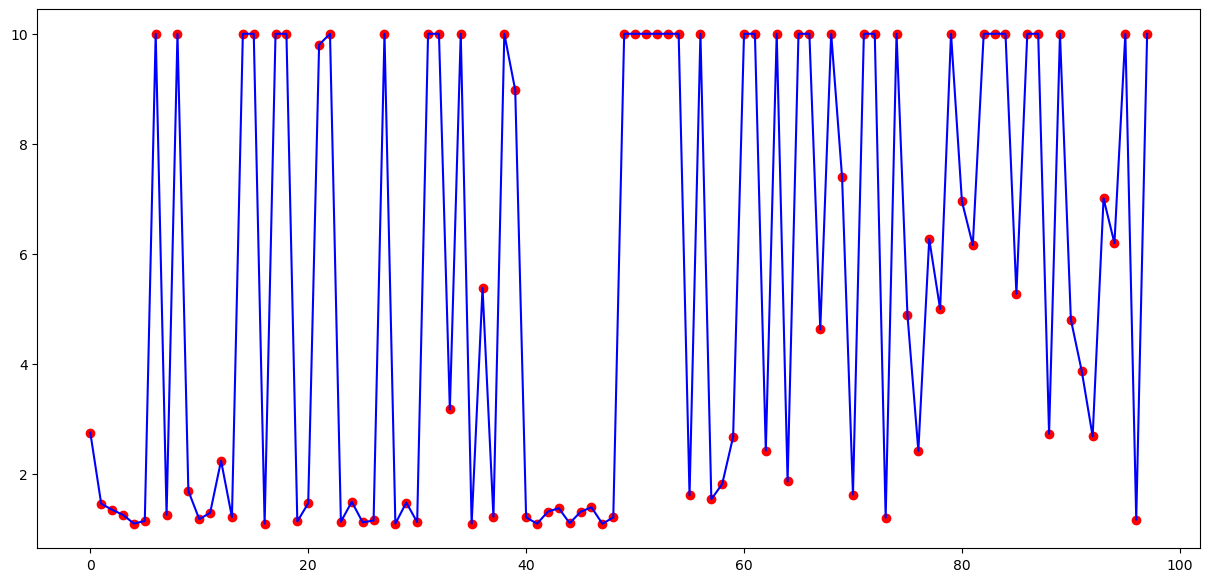

In [168]:
values = function_accuracyT.copy()

values = [10 if v > 10 else v for v in values]

plt.figure(figsize=(15, 7))
xs = np.arange(98)
plt.scatter(xs,values,color='red',marker='o')
plt.plot(xs,values,color='blue')

In [164]:
function_accuracy_brez1 = []
function_accuracy_brez2 = []
function_accuracy_brez3 = []

function_accuracy_z = []

for eqIndex in range(20, len(data)-50):
    
    k = tournament_selection(1000, 2000, eqIndex)

    brez1 = ga_generating(100, 10, eqIndex,1)
    brez1= sort_dict(brez1)

    brez2 = ga_generating(100, 10, eqIndex,2)
    brez2 = sort_dict(brez2)
    
    brez3 = ga_generating(100, 10, eqIndex,3)
    brez3 = sort_dict(brez3)

    val = list(k)[0][0]
    val_brez1 = list(brez1)[0]
    val_brez2 = list(brez2)[0]
    val_brez3 = list(brez3)[0]



    function_accuracy_z.append(val)
    function_accuracy_brez1.append(val_brez1)
    function_accuracy_brez2.append(val_brez2)
    function_accuracy_brez3.append(val_brez3)

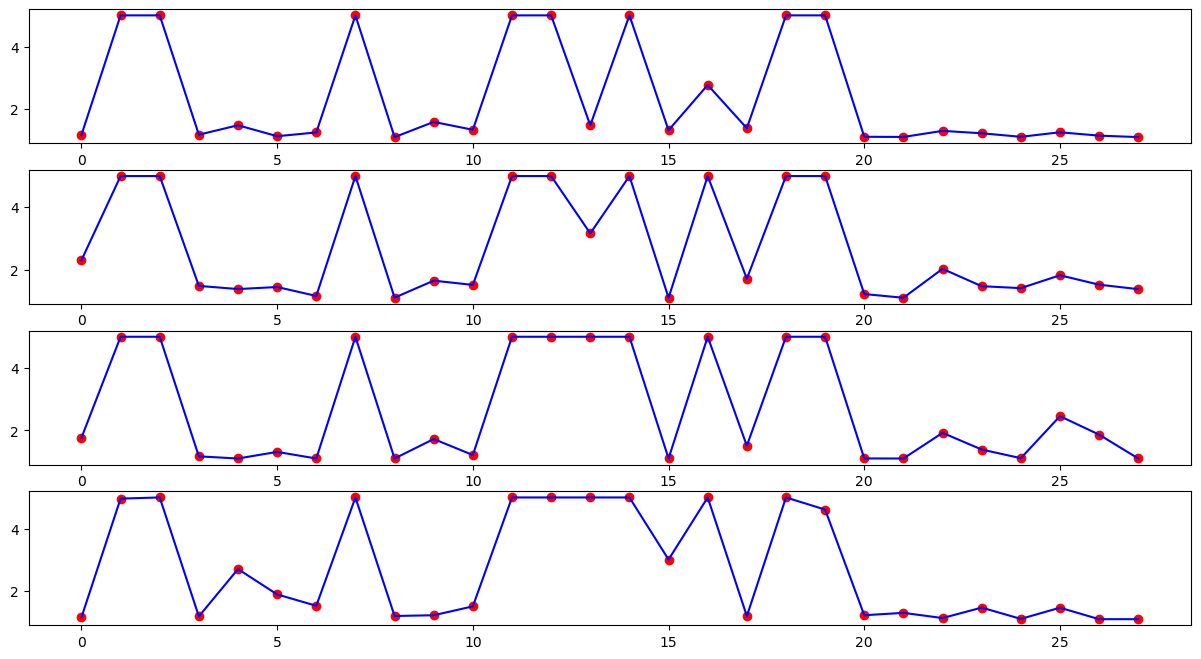

In [165]:
values_z = function_accuracy_z.copy()
values_brez1 = function_accuracy_brez1.copy()
values_brez2 = function_accuracy_brez2.copy()
values_brez3 = function_accuracy_brez3.copy()


values_z = [5 if v > 5 else v for v in values_z]
values_brez1 = [5 if v > 5 else v for v in values_brez1]
values_brez2 = [5 if v > 5 else v for v in values_brez2]
values_brez3 = [5 if v > 5 else v for v in values_brez3]


plt.figure(figsize=(15, 8))

xs = np.arange(len(values_z))
plt.subplot(411)
plt.scatter(xs,values_z,color='red',marker='o')
plt.plot(xs,values_z,color='blue')
plt.subplot(412)
plt.scatter(xs,values_brez1,color='red',marker='o')
plt.plot(xs,values_brez1,color='blue')
plt.subplot(413)
plt.scatter(xs,values_brez2,color='red',marker='o')
plt.plot(xs,values_brez2,color='blue')
plt.subplot(414)
plt.scatter(xs,values_brez3,color='red',marker='o')
plt.plot(xs,values_brez3,color='blue')

In [155]:
function_accuracy_brez1 = []
function_accuracy_brez2 = []
function_accuracy_brez3 = []

function_accuracy_z = []

for eqIndex in range(20, len(data)-50):
    
    k = ga_N(800, 10, eqIndex)
    k = sort_dict(k)

    brez1 = ga_generating(100, 10, eqIndex,1)
    brez1= sort_dict(brez1)

    brez2 = ga_generating(100, 10, eqIndex,2)
    brez2 = sort_dict(brez2)
    
    brez3 = ga_generating(100, 10, eqIndex,3)
    brez3 = sort_dict(brez3)

    val = list(k)[0]
    val_brez1 = list(brez1)[0]
    val_brez2 = list(brez2)[0]
    val_brez3 = list(brez3)[0]



    function_accuracy_z.append(val)
    function_accuracy_brez1.append(val_brez1)
    function_accuracy_brez2.append(val_brez2)
    function_accuracy_brez3.append(val_brez3)


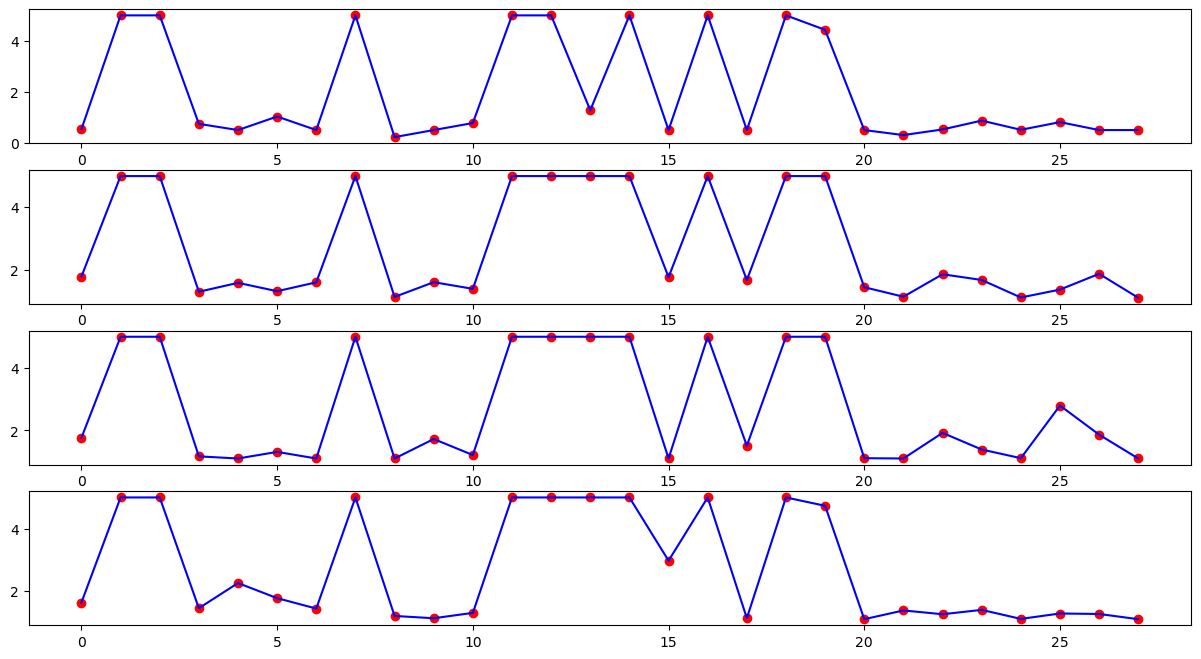

In [157]:
values_z = function_accuracy_z.copy()
values_brez1 = function_accuracy_brez1.copy()
values_brez2 = function_accuracy_brez2.copy()
values_brez3 = function_accuracy_brez3.copy()


values_z = [5 if v > 5 else v for v in values_z]
values_brez1 = [5 if v > 5 else v for v in values_brez1]
values_brez2 = [5 if v > 5 else v for v in values_brez2]
values_brez3 = [5 if v > 5 else v for v in values_brez3]


plt.figure(figsize=(15, 8))

xs = np.arange(len(values_z))
plt.subplot(411)
plt.scatter(xs,values_z,color='red',marker='o')
plt.plot(xs,values_z,color='blue')
plt.subplot(412)
plt.scatter(xs,values_brez1,color='red',marker='o')
plt.plot(xs,values_brez1,color='blue')
plt.subplot(413)
plt.scatter(xs,values_brez2,color='red',marker='o')
plt.plot(xs,values_brez2,color='blue')
plt.subplot(414)
plt.scatter(xs,values_brez3,color='red',marker='o')
plt.plot(xs,values_brez3,color='blue')

V spodnjem primeru vidimo kako se različne najmanjše dolžine enačb razlikujejo v točnosti, pri populaciji velikosti 400 in 10 generacijami.

In [35]:
function_accuracy33 = []

defLenExpres = [1, 5, 7, 12]

for i, dle in enumerate(defLenExpres):
    function_accuracy2 = []
    print(f"Default min expression len index: {i}")

    for eqIndex in range(0, len(data)):
        
        k = ga(400, 10, eqIndex, [1,1,1,2,2,3,2,3,3,3,3,3,3,3,3,3,3,3,3,3], dle)
        k = sort_dict(k)

        val = list(k)[0]

        function_accuracy2.append(val)
    function_accuracy33.append(function_accuracy2)

Default min expression len index: 0
Default min expression len index: 1
Default min expression len index: 2
Default min expression len index: 3


In [36]:
df = pd.DataFrame(np.array(function_accuracy33).T)
df.to_csv('DifDefLenExpr.csv', index=False, header=False)

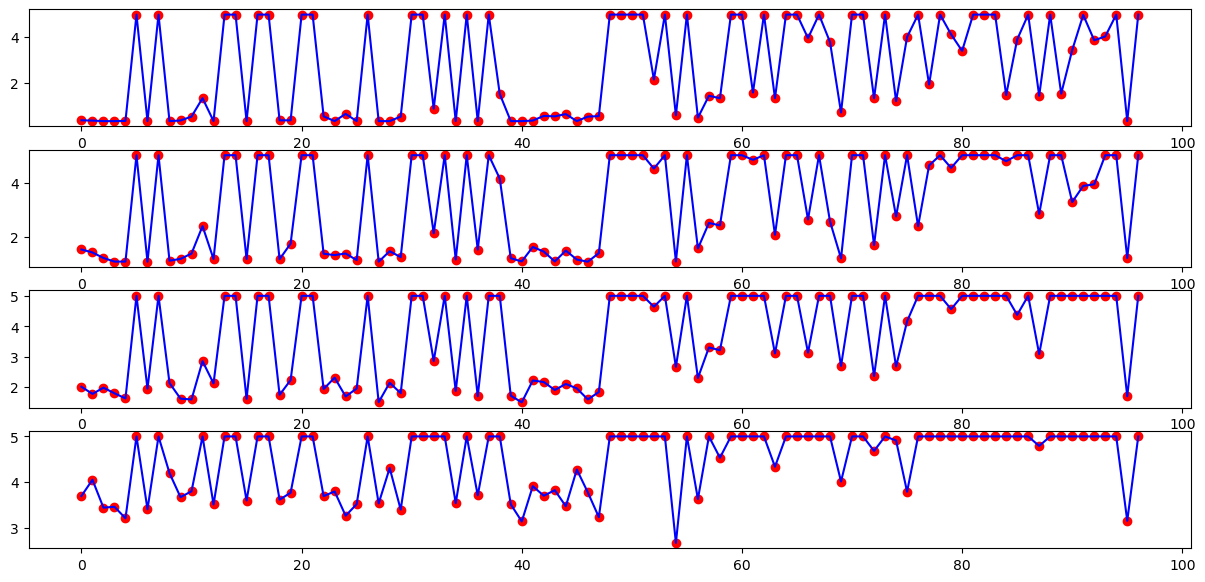

In [156]:
function_acc = pd.read_csv("./DifDefLenExpr.csv", sep=',')
rowsCount = function_acc.shape[1]
plt.figure(figsize=(15, 7))

for i in range(rowsCount):
    curRow = function_acc.iloc[:,i]
    values = [5 if v > 5 else v for v in curRow]
    plt.subplot(4,1,i+1)
    xs = np.arange(len(curRow))
    plt.scatter(xs,values,color='red',marker='o')
    plt.plot(xs,values,color='blue')
plt.show()

Za prikaz casovne zahtevonosti geneteskega algoritma

In [38]:
for eqIndex in range(0, len(data)):
    k = ga(200, 10, eqIndex)
    k = sort_dict(k)
# 4m 8.7s

In [39]:
for eqIndex in range(0, len(data)):
    k = ga(200, 20, eqIndex)
    k = sort_dict(k)
#8m 20.8s

In [40]:
for eqIndex in range(0, len(data)):
    k = ga(200, 30, eqIndex)
    k = sort_dict(k)
#12m 33.6s

In [41]:
for eqIndex in range(0, len(data)):
    k = ga(200, 40, eqIndex)
    k = sort_dict(k)
#16m 50.4s

In [42]:
for eqIndex in range(0, len(data)):
    k = ga(200, 50, eqIndex)
    k = sort_dict(k)
#20m 59.5s

In [43]:
for eqIndex in range(0, len(data)):
    k = ga(10, 10, eqIndex)
    k = sort_dict(k)
#10.4s

In [44]:
for eqIndex in range(0, len(data)):
    k = ga(50, 10, eqIndex)
    k = sort_dict(k)
#1m

In [45]:
for eqIndex in range(0, len(data)):
    k = ga(100, 10, eqIndex)
    k = sort_dict(k)
#2m 2.6s

In [46]:
for eqIndex in range(0, len(data)):
    k = ga(150, 10, eqIndex)
    k = sort_dict(k)
#3m 5.7s

In [47]:
for eqIndex in range(0, len(data)):
    k = ga(200, 10, eqIndex)
    k = sort_dict(k)
#4m 7.9s

In [175]:
for eqIndex in range(0, len(data)):
    k = tournament_selection(200, 50, eqIndex)

In [171]:
for eqIndex in range(0, len(data)):
    k = tournament_selection(600, 50, eqIndex)

In [172]:
for eqIndex in range(0, len(data)):
    k = tournament_selection(1000, 50, eqIndex)

In [173]:
for eqIndex in range(0, len(data)):
    k = tournament_selection(1400, 50, eqIndex)

In [174]:
for eqIndex in range(0, len(data)):
    k = tournament_selection(1800, 50, eqIndex)

In [182]:
for eqIndex in range(0, len(data)):
    k = tournament_selection(400, 10, eqIndex)

In [183]:
for eqIndex in range(0, len(data)):
    k = tournament_selection(400, 15, eqIndex)

In [184]:
for eqIndex in range(0, len(data)):
    k = tournament_selection(400, 20, eqIndex)

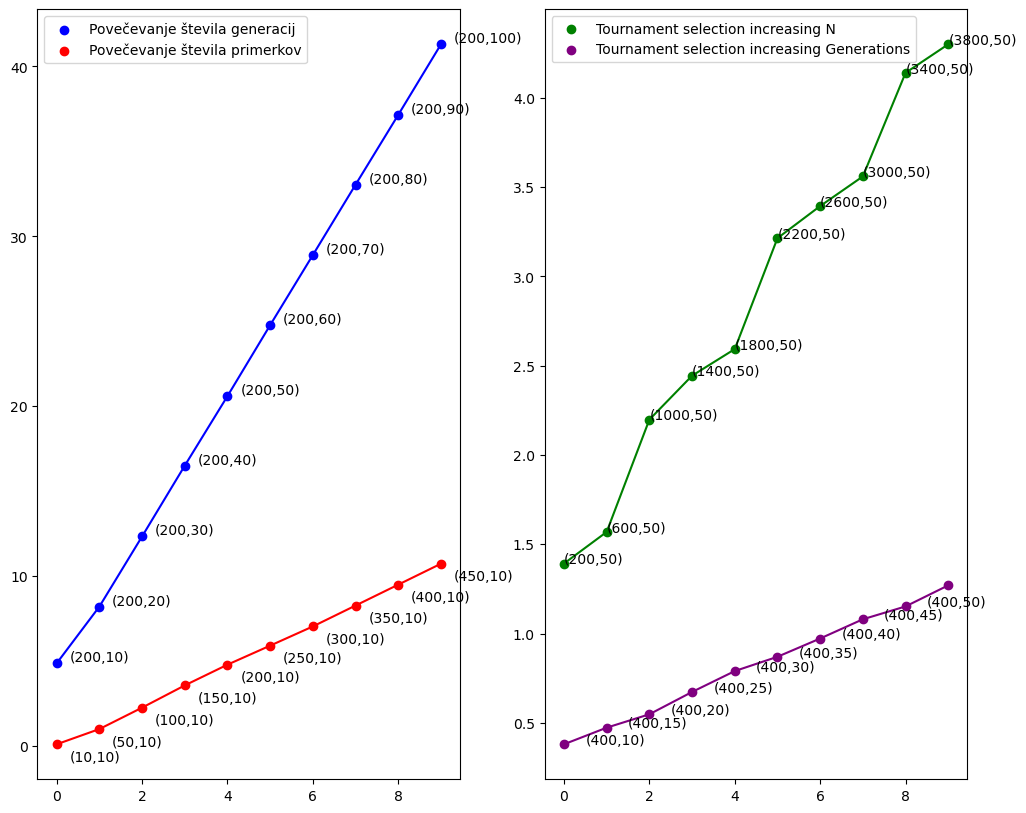

In [197]:
values = [4.87,8.208,12.336,16.504,20.596,24.774,28.9,33.04,37.15,41.3]
values2 = [0.104,1,2.26,3.57,4.79,5.91,7.04,8.27,9.5,10.732]
values3 = [1.392,1.569,2.198,2.444,2.593,3.214,3.394,3.56,4.14,4.3]
values4 = [0.38,0.473,0.548,0.673,0.79,0.87,0.9723,1.08,1.152,1.27]

txt1 = ['(200,10)','(200,20)','(200,30)','(200,40)','(200,50)','(200,60)','(200,70)','(200,80)','(200,90)','(200,100)']
txt2 = ['(10,10)','(50,10)','(100,10)','(150,10)','(200,10)','(250,10)','(300,10)','(350,10)','(400,10)','(450,10)']

xs = np.arange(10)
plt.figure(figsize=(12,10))
plt.xlabel("Index")
plt.ylabel("Minutes")
plt.subplot(121)
plt.scatter(xs,values,color='blue',marker='o',label='Povečevanje števila generacij')
plt.plot(xs,values,color='blue')
for ix,txt in enumerate(txt1):
    plt.annotate(txt,(xs[ix]+0.3,values[ix]+0.1))
plt.scatter(xs,values2,color='red',marker='o',label='Povečevanje števila primerkov')
plt.plot(xs,values2,color='red')
for ix,txt in enumerate(txt2):
    plt.annotate(txt,(xs[ix]+0.3,values2[ix]-1))
plt.legend()

plt.subplot(122)
plt.scatter(xs,values3,color='green',marker='o',label='Tournament selection increasing N')
plt.plot(xs,values3,color='green')
num = 200
for ix in range(len(values3)):
    txt = f"({num},50)"
    plt.annotate(txt,(xs[ix],values3[ix]))
    num+=400

plt.scatter(xs,values4,color='purple',marker='o',label='Tournament selection increasing Generations')
plt.plot(xs,values4,color='purple')
num = 10
for ix in range(len(values3)):
    txt = f"(400,{num})"
    plt.annotate(txt,(xs[ix]+0.5,values4[ix]))
    num+=5
plt.legend()

# plt.show()